## Final Project Proposal


__What question/questions are you trying to solve?__
* How well can we guess the final auction price of an (X) on eBay, before we list it?
* How can I help my information security specialist friend classify and visualize incoming requests?


__What are the outcomes you think you will find, and then so what?__

* It is either trivial, challenging, or near-impossible to train an ML model to accurately guess the price of an (X)
* The cyber-security field is either rife with opportunity for data science innovation, or too far out of my domain expertise for me to be helpful


__How would someone, or some entity take action upon learning this?__
* In the event that my eBay model is confidently predictive, one could use it to help arbitrage goods across platforms.
* In the event that my info-sec tool is useful, white-hat pen-testers could use it to visualize apache logs and things.


__What version this question would allow me to find an answer in 2-3 days?__
* How accurate is an eBay predictive model that just goes off of the basic features (with no NLP or CNN action)?
* What if we just visualized incoming web requests / Fail2ban logs?


__What version of this question would allow me/motivate me to work on this problem even after completing Flatiron School?__
* For which eBay product category can I make the most accurate valuator model? Can I put it into practice?
* What other tools can I make for the information security field?


__What are some data sources that would allow you to answer this?__
* eBay API
* My friend in the NAVY


__What is the ideal data you would hope to gather to answer this question?__
* Tens of thousands of previous eBay auctions
* Tens of thousands of server logs and things


__What about potentially missing data, that could cause omitted variable bias?__
* There might be a lot of this, so I will have to get creative about making my sparse data less sparse
* Server logs will not have this problem mostly.


__How will you present your data? Will it be a jupyter notebook presentation or a Dashboard.__
* Dash was a good time, would use again
* Ideally users can make a new eBay listing, run it through the model to get a price guess
* Server log visualizations would be a geo-viz of some kind like a kepler.gl object of some kind


__How will you use regression and/or classification?__
* eBay value estimator will obviously guess the price of new listings
* Info-Sec project would probably try to classify incoming requests as malicious, safe, or unknown or something


__What are the challenges you foresee with this project?__
* Figuring out good model stacking and ninja feature engineering techniques
* Domain-specific challenges having to do with the eBay API responses
* 5000-request daily limit with eBay API


__What are your next steps moving forward?__
* Making hecka requests to the eBay API and collecting data
* Poking and prodding the data every which way possible
* NLP pipeline for titles, description, condition description text
* Think about how I might use the images to help guess price

In [1]:
import json, os, io, requests, csv

import pandas as pd
import numpy as np

from scipy.stats import boxcox

from datetime import datetime
import matplotlib.pyplot as plt

### Here's a JSON Reader

In [2]:
def read_axe_jsons(axe_num):
    with open('axe_listings/%s' % (axe_num), "r") as read_file:
        listing = json.load(read_file)
    with open('axe_specs/%s' % (axe_num), "r") as read_file:
        specs = json.load(read_file)
    return {'listing': listing, 'specs': specs}

### Here's a Guitar (Axe) Class with *Lots* of Attributes (Features)

Some ducking was required for auctions without certain details.

In [48]:
class Axe:
    def __init__(self, axe_num=None):
        self.id = axe_num
        self.__body = read_axe_jsons("%s" % (axe_num))
        self.price_usd = float(self.__body['listing']['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        self.title = self.__body['listing']['title'][0]
        self.market = self.__body['listing']['globalId'][0]
        if self.__body['listing'].get('galleryURL'):
            self.pic = self.__body['listing']['galleryURL'][0]
        else: self.pic = None
        
        if self.__body['listing'].get("pictureURLLarge"):
            self.pic_big = self.__body['listing']['pictureURLLarge'][0]
        else:
            self.pic_big = None
        
        self.url = self.__body['listing']['viewItemURL'][0]
        self.autopay = self.__body['listing']['autoPay'][0] == 'true'
        
        self.country_seller = self.__body['listing']['country'][0]
        if self.country_seller not in ['US', 'JP', 'CA', 'GB']:
            self.country_seller = 'OTHER'
        
        self.ship_type = self.__body['listing']['shippingInfo'][0]['shippingType'][0]
        self.ship_expedite = self.__body['listing']['shippingInfo'][0]['expeditedShipping'][0] == 'true'
        
        if self.__body['listing']['shippingInfo'][0].get('handlingTime'):
            self.ship_handling_time = int(self.__body['listing']['shippingInfo'][0]['handlingTime'][0])
        else: 
            self.ship_handling_time = None
        
        self.zip = self.__body['listing'].get('postalCode')
        
        self.start_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['startTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        self.end_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['endTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        
        self.start_weekday = self.start_time.weekday()
        self.end_weekday = self.end_time.weekday()
        
        self.__duration = (self.end_time - self.start_time)
        self.duration = round(float(self.__duration.days*24) + float(self.__duration.seconds/60/60), 2)
        
        self.returns = self.__body['listing']['returnsAccepted'][0] == 'true'
        
        # End Generic Section // Begin Specs Section:
        
        if self.__body['specs'].get('Description'):
            self.description = self.__body['specs']['Description']
        else:
            self.description = None
        
        self.pic_quantity = len(self.__body['specs']['PictureURL'])

        if self.__body['specs']['Seller'].get('FeedbackScore'):
            self.seller_feedback_score = float(self.__body['specs']['Seller']['FeedbackScore'])
        else: 
            self.seller_feedback_score = None
            
        
        self.seller_positive_percent = float(self.__body['specs']['Seller']['PositiveFeedbackPercent'])
        self.subtitle = self.__body['specs'].get('Subtitle')
        self.condition_description = self.__body['specs'].get('ConditionDescription')
        
        # Niche niche specifics:
        
        if self.returns:
            if self.__body['specs']['ReturnPolicy'].get('ReturnsWithin'):
                self.returns_time = int(self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[0])
        else: self.returns_time = None
            
        # Very ultra niche specifics, more ducking required:
        
        if self.__body['specs'].get('ItemSpecifics'):
            self.__attrs = {prop['Name']:prop['Value'][0] 
                            for prop in self.__body['specs']['ItemSpecifics']['NameValueList']}
            self.brand = self.__attrs.get('Brand')
            self.model = self.__attrs.get('Model')
            
            if self.__attrs.get('Model Year'):
                self.year = self.__attrs.get('Model Year')[:4]
                if self.year != None:
                    try:
                        self.year = int(self.year)
                        if self.year == 86:
                            self.year = 1986
                        if self.year < 1800:
                            self.year = None
                    except ValueError:
                        self.year = None      
            else: 
                self.year = None
                
            self.material = self.__attrs.get('Body Material')
            self.right_left_hand = self.__attrs.get('Right-/ Left-Handed')
            self.country_manufacture = self.__attrs.get('Country/Region of Manufacture')
            self.body_type = self.__attrs.get('Body Type')
            self.string_config = self.__attrs.get('String Configuration')
            self.color = self.__attrs.get('Body Color')
            if self.color:
                self.color = self.color.upper()
                if "CHERRY" in self.color:
                    self.color = "RED"
                if "SUNBURST" in self.color:
                    self.color = "SUNBURST"
                if "BURST" in self.color:
                    self.color = "SUNBURST"
                if "MAHOGANY" in self.color:
                    self.color = "NATURAL"
                if "BLUE" in self.color:
                    self.color = "BLUE"
                if "TURQUOISE" in self.color:
                    self.color = "BLUE"
                if "TEAL" in self.color:
                    self.color = "BLUE"
                if "RED" in self.color:
                    self.color = "RED"
                if "BLACK" in self.color:
                    self.color = "BLACK"
                if "EBONY" in self.color:
                    self.color = "BLACK"
                if "WHITE" in self.color:
                    self.color = "WHITE"
                if "GREEN" in self.color:
                    self.color = "GREEN"
                if "NATURAL" in self.color:
                    self.color = "NATURAL"
                if "BLONDE" in self.color:
                    self.color = "NATURAL"
                if "BLOND" in self.color:
                    self.color = "NATURAL"
                if "BEIGE" in self.color:
                    self.color = "NATURAL"
                if "MAPLE" in self.color:
                    self.color = "NATURAL"
                if "BUTTERSCOTCH" in self.color:
                    self.color = "NATURAL"
                if "WALNUT" in self.color:
                    self.color = "NATURAL"
                if "TOBACCO" in self.color:
                    self.color = "NATURAL"
                if "BROWN" in self.color:
                    self.color = "NATURAL"
                if "CREAM" in self.color:
                    self.color = "WHITE"
                if "GOLD" in self.color:
                    self.color = "YELLOW"
                if "YELLOW" in self.color:
                    self.color = "YELLOW"
                if "FIREGLO" in self.color:
                    self.color = "RED"
                if "WINE" in self.color:
                    self.color = "RED"
                if "BURGANDY" in self.color:
                    self.color = "RED"
                if "BURGUNDY" in self.color:
                    self.color = "RED"
                if "MULTI-COLOR" in self.color:
                    self.color = "MULTICOLOR"
                if "AMBER" in self.color:
                    self.color = "YELLOW"
                if "WOOD" in self.color:
                    self.color = "NATURAL"
                if "COPPER" in self.color:
                    self.color = "RED"
                if "PEWTER" in self.color:
                    self.color = "GRAY"
                if "GRAY" in self.color:
                    self.color = "GRAY"
                if self.color not in ['BLACK', 'RED', 'SUNBURST', 'WHITE', 'NATURAL', 'BLUE', 'YELLOW',
                                       'GREEN', 'SILVER']:
                    self.color = "OTHER"
                
        else:
            self.__attrs = self.brand = self.model = self.year = None
            self.material = self.right_left_hand = self.country_manufacture = None
            self.body_type = self.string_config = self.color = None    

### Loop Through All Guitar JSON Data Files, Instantiate AXE Class Objects

In [49]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignore .DS_Store

In [50]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        axes.append(this_axe)
    except ValueError:
        pass

Our API calls were limited to guitars over 100 bucks, but that made a weird artificial mode at 100 so now we'll just drop the guitars priced at 100:

In [51]:
axes = [axe for axe in axes if axe.price_usd > 100]

In [52]:
len(axes)

14255

********

## EDA

**********

__Price Distribution:__

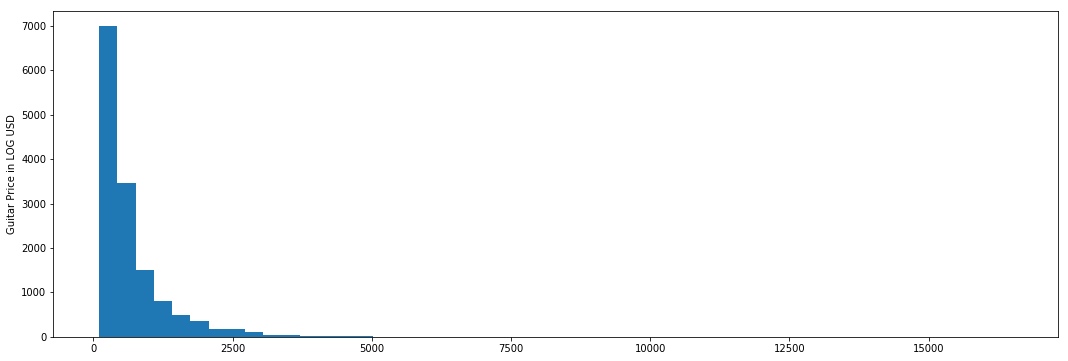

In [8]:
plt.figure(figsize = (18,6))
plt.hist([axe.price_usd for axe in axes], bins=50)
plt.ylabel('Guitar Price in LOG USD')
plt.show()

**Box-Cox Transformed Price Distribution:**

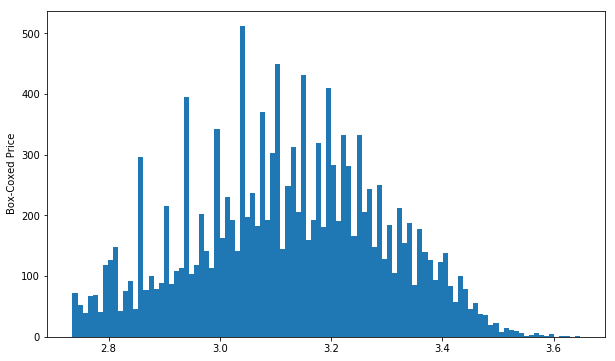

In [9]:
plt.figure(figsize = (10,6))
plt.hist(boxcox(np.array([axe.price_usd for axe in axes]), -.25), bins=100)
plt.ylabel('Box-Coxed Price')
plt.show()

**********

__Text Fields, for NLP:__

Listing Title:

In [10]:
[axe.title for axe in axes][:10]

['Fender Telecaster Vintage Electric Guitar MIM, 1994, Crimson Red',
 'NIIBORI UNIQUE RARE ELECTRIC ALTO GUITARS FUJIGEN MADE IN JAPAN CIRCLE FRETTING ',
 'Vintage 1962 Hofner Model 172 White Vinyl Snakeskin Solid Body Electric Guitar ',
 '2015 Gibson Les Paul LPM',
 'Ibanez Gio GRGBD120XL Left Handed Electric Guitar in Black Locking Tremelo',
 'Fender EVH Wolfgang Special Stealth WITH HARDSHELL CASE',
 "1960's Teisco Del Rey ET-200  MIJ Made in Japan Electric Guitar Sunburst ",
 'Jackson  Dinky JS  Gun Metal Gray',
 "Vintage Greco/Matsumoko Japanese japan Stratocaster White 70's/80's?",
 'Ibanez RG420EG SBK (Spiderweb Black) Guitar. Free Gig Bag & Free Shipping.']

Mean Length of Title:

In [11]:
mean_title_len = sum(len(axe.title) for axe in axes)/len(axes)
print(f'{round(mean_title_len, 2)} characters per title on average')

58.48 characters per title on average


Condition Description:

In [12]:
[axe.condition_description for axe in axes if axe.condition_description != None][-5:]

['Overall, this guitar is clean - but it is NOT 100% perfect.  It has  a couple of dings, small impressions, light scratches. The back of the body has NO buckle rash. One area of the fretboard has light surface imperfections. A few area of the frets have light visible wear.  The upper area of he back of the headstock has light impressions that look like not too light  / not too deep scratches and some cloudiness. Specific details are in the description.  The gig bag is fine -  is brand new and the padding is thick..',
 'Plays and sounds awesome!! Excellent Condition!! Only signs of very light playwear that is hard to see. Please see photos.',
 'Plays and sounds awesome!! Rare Mexico made model.  Shows some signs of light wear with a few light dings and light scratching.  Please see photos.',
 'Item history unknown; Works; has cracked head; cosmetic damage to body',
 'Plays and sounds awesome!! Good Condition!! Shows some signs of light wear with a few light dings and very light scratch

In [13]:
print(f'{round((len([axe.condition_description for axe in axes if axe.condition_description != None]) / len(axes)*100),2)}% include a condition description.')

31.93% include a condition description.


Example of Description Full Text:

In [14]:
[axe.description for axe in axes][2000]

'Here is a 2001 Gibson es-335. The Guitar is in excellent all original condition and comes with the original case. All latches and the lock work on the case. The Guitar is beautiful with nice flame to the front and back of the body as well as the sides. Frets show very little wear. Not much wear to the guitar at all. No breaks, cracks or any repairs. Solid old Gibson from 2001.'

***********

__Number of Pics on eBay listing:__

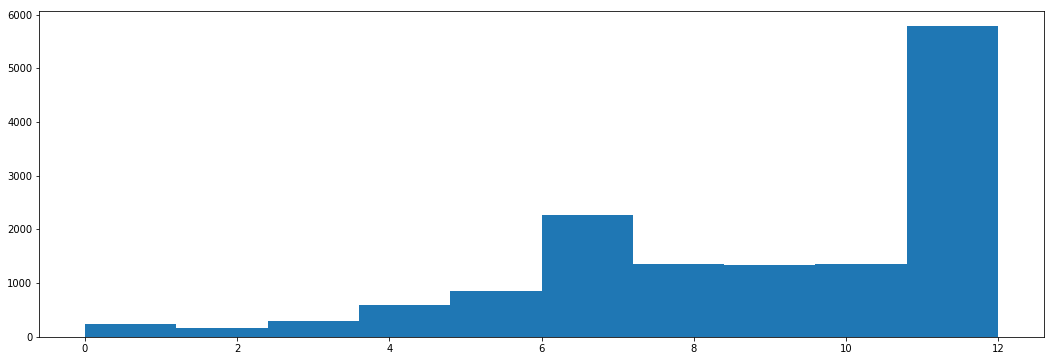

In [15]:
plt.figure(figsize = (18,6))
plt.hist([axe.pic_quantity for axe in axes])
plt.show()

__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [16]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs2.ebaystatic.com/m/mi0yHKrebkFb2j2Q2Hq94nQ/140.jpg',
 'http://thumbs2.ebaystatic.com/m/mQmZbPocJHLChrfH72b7B4g/140.jpg',
 'http://thumbs1.ebaystatic.com/m/mJ8Lff1v59jsIxRDNQd7zNg/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mFax7qfKyVwHNv_LkUoh8uQ/140.jpg',
 'http://thumbs3.ebaystatic.com/m/maT-GoD60SDnPBWiBilfcSw/140.jpg']

**********

**Shipping Type:**

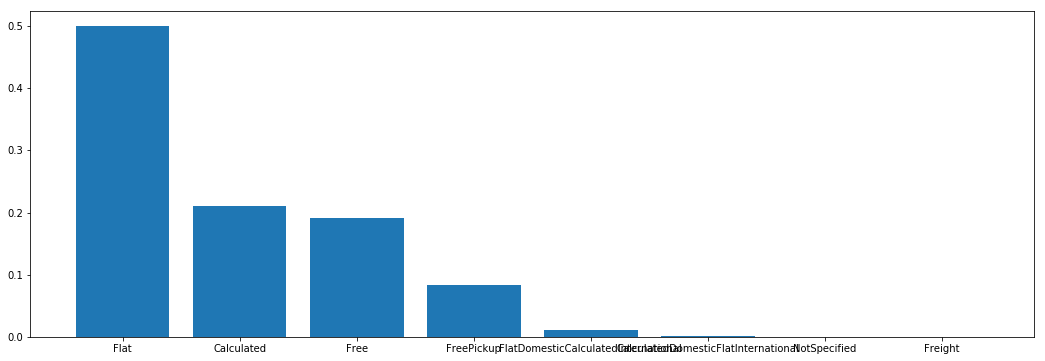

In [17]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

**Handling Time in Days:**

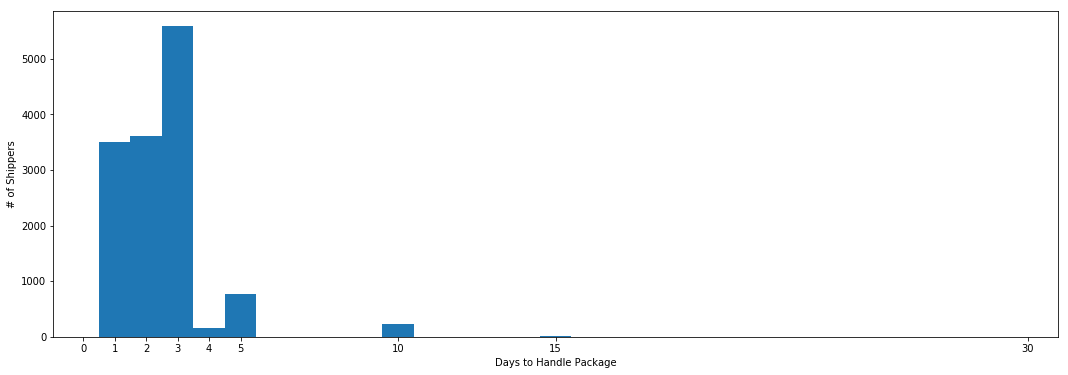

In [18]:
plt.figure(figsize = (18,6))
times = pd.Series([axe.ship_handling_time for axe in axes if axe.ship_handling_time != None])
plt.hist(times, bins=np.arange(max(times))+.5)
plt.xticks(sorted(times.value_counts().index))
plt.xlabel('Days to Handle Package')
plt.ylabel('# of Shippers')
plt.show()

__Duration of Auction in Days__:

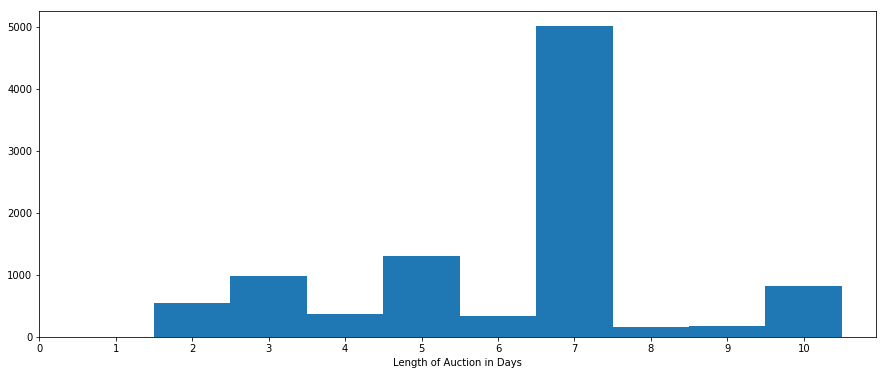

In [19]:
plt.figure(figsize = (15,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Length of Auction in Days')
plt.show()

***

**Countries of Sellers:**

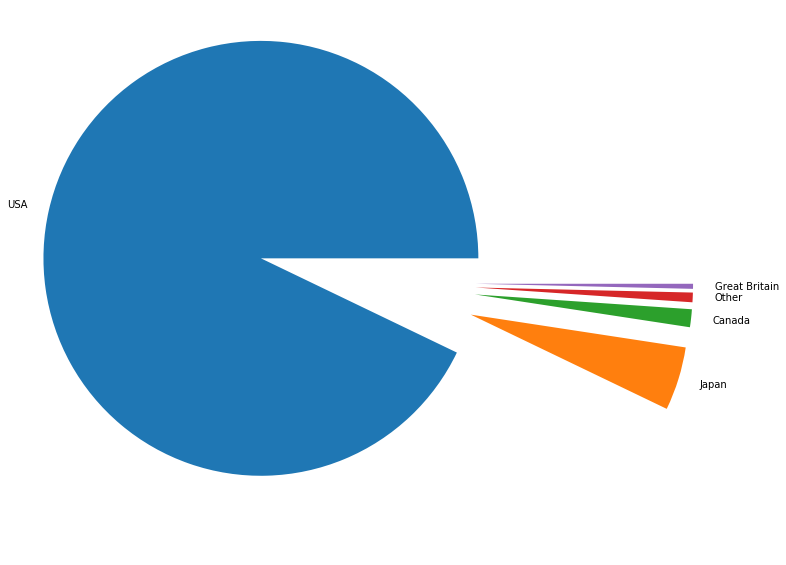

In [58]:
plt.figure(figsize = (10,10))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.pie(countries.values, labels=['USA', 'Japan', 'Canada', 
                                  'Other','Great Britain'], 
                            explode = np.full(len(countries), .5))
plt.show()

In [64]:
pd.Series([axe.country_manufacture for axe in axes]).value_countse_counts()

United States         2122
Japan                  873
Mexico                 498
Korea, Republic of     488
China                  378
Indonesia              343
Unknown                 47
Canada                  28
Italy                   11
Germany                 10
Sweden                   8
Taiwan                   8
United Kingdom           7
India                    7
Vietnam                  6
N/A                      5
France                   2
japan                    2
Switzerland              2
Uzbekistan               1
Puerto Rico              1
Colombia                 1
Bahamas                  1
Korea                    1
Ukraine                  1
USA                      1
Czech Republic           1
Georgia                  1
Russian Federation       1
Israel                   1
Finland                  1
Togo                     1
dtype: int64

***

**Offering Expedited Shipping:**

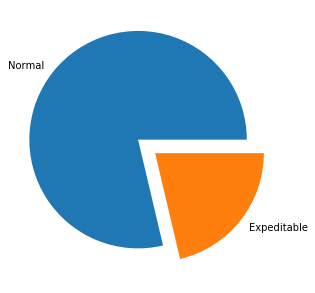

In [21]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (5,5))
plt.pie(exp.values, explode=[.1,.1], labels=['Normal', 'Expeditable'])
plt.show()

***********

**Weekday of Auction Start:**

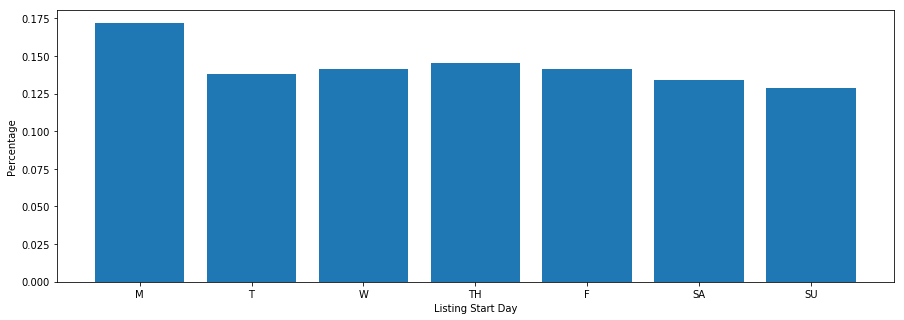

In [22]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Weekday of Auction End:**

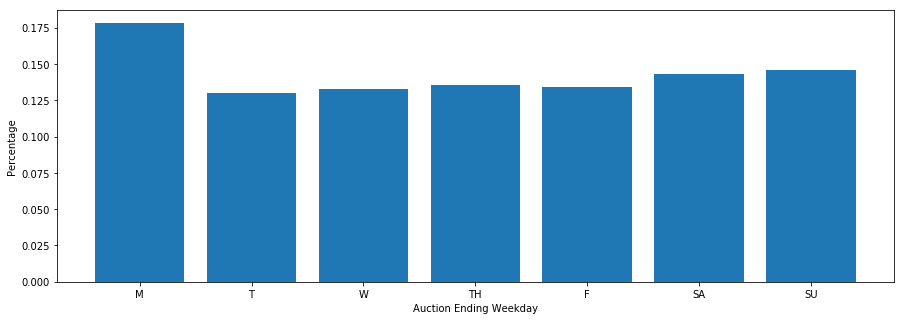

In [23]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

****

**Percentage of Auctions Offering Returns:**

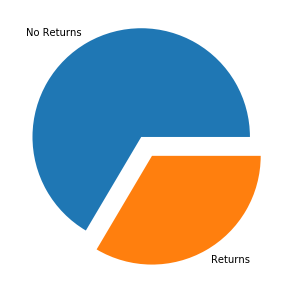

In [24]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (5,5))
plt.pie(returns.values, explode=[.1,.1], labels=['No Returns', 'Returns'])
plt.show()

****

**Return Time Window** of sellers offering returns:

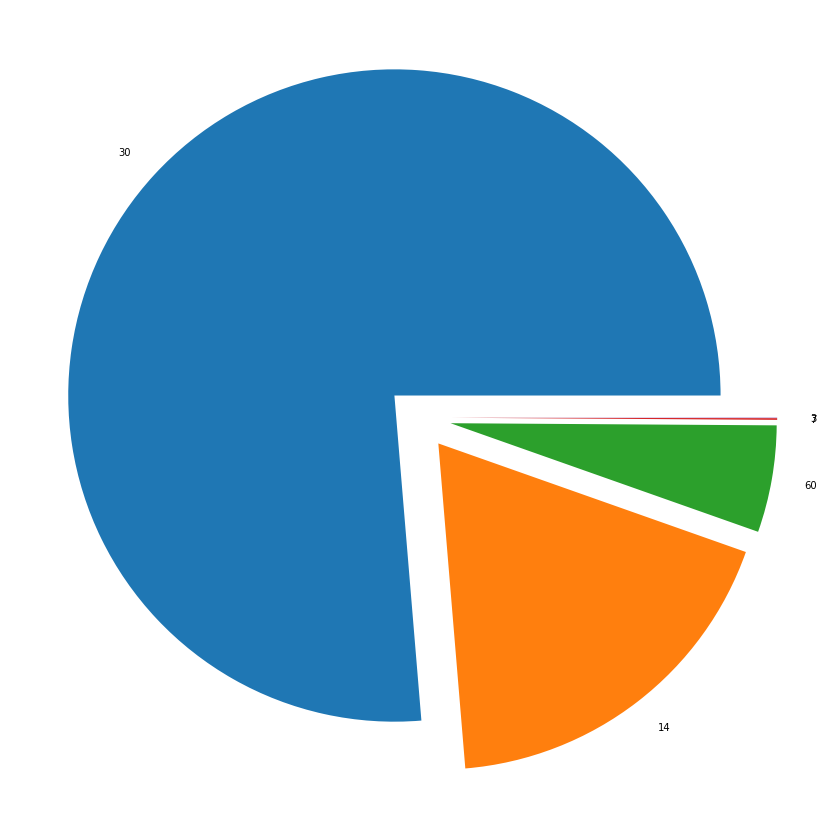

In [25]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time != None]).value_counts()
plt.figure(figsize = (15,15))
plt.pie(returns.values, explode=np.full(len(returns), .1), labels = returns.index)
plt.show()

***

__Guitar Body Colors:__

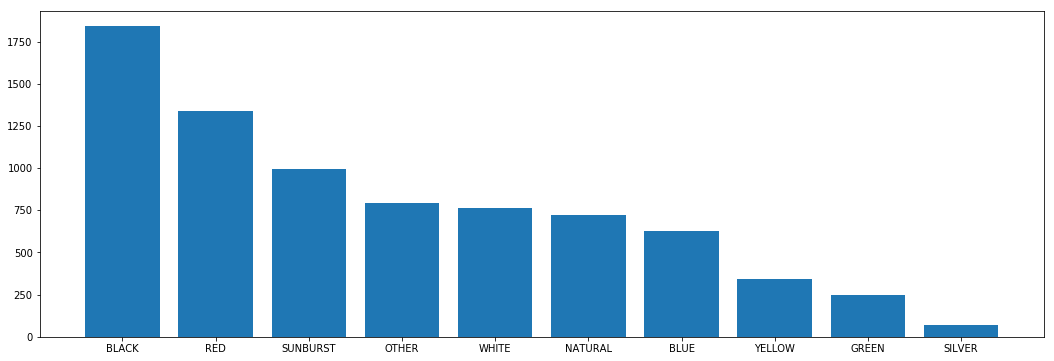

In [26]:
plt.figure(figsize = (18,6))
colors = pd.Series([axe.color for axe in axes if axe.color != None]).value_counts()
plt.bar(colors.index, colors.values)
plt.show()

In [27]:
per = round((sum(pd.Series([axe.color for axe in axes if axe.color != None]).value_counts() / len(axes))*100),2)
print(f'{per}% of listings include a body color where they\'re supposed to.')

54.39% of listings include a body color where they're supposed to.


***

__Age of Guitars:__

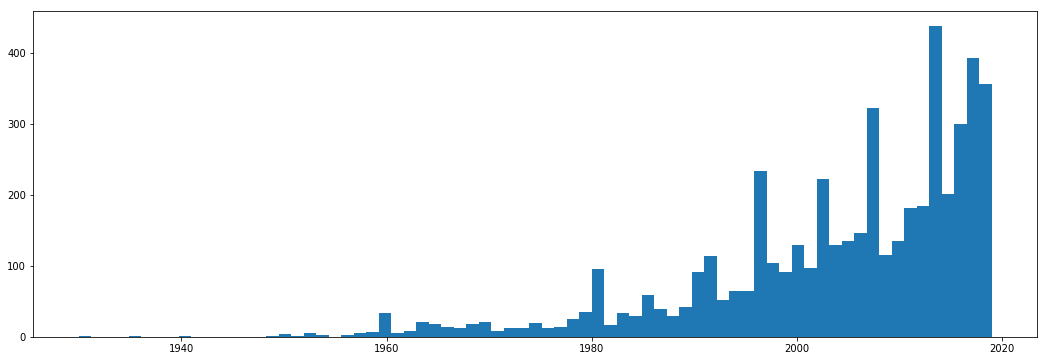

In [28]:
ages = pd.Series([axe.year for axe in axes if axe.year])
plt.figure(figsize = (18,6))
plt.hist(ages, bins=len(ages.value_counts().index))
plt.show()

In [29]:
print(f'{round((len(ages) / len(axes) * 100),2)}% of sellers put the year where they\'re supposed to.')

34.87% of sellers put the year where they're supposed to.


***

__US Seller Locations, by Zip Code:__

In [30]:
sales = [(axe.zip[0], axe.start_time) for axe in axes if axe.country_seller == 'US' and axe.zip != None]

In [31]:
def get_usa_zips(url):
    usa_zips = {}
    census_zip_latlon = io.StringIO(requests.get(url).text)
    dialect = csv.Sniffer().sniff(census_zip_latlon.read(1024))
    census_zip_latlon.seek(0)
    reader = csv.reader(census_zip_latlon, dialect)
    for row in reader:
        usa_zips[row[0]] = (row[1], row[2])
    return usa_zips

In [32]:
usa_zips = get_usa_zips(r'https://goo.gl/oYwpRM')

In [33]:
sales = [sale for sale in sales if sale[1] > datetime.strptime('2018-08-01', '%Y-%m-%d')]

In [34]:
def write_kepler_csv():
    with open('for_kepler.csv', mode='w') as sale_lat_long_datetime_file:

        sales_writer = csv.writer(sale_lat_long_datetime_file, delimiter=',', 
                                                           quotechar='"', 
                                                           quoting=csv.QUOTE_MINIMAL)

        ## The sample data set I got from the kepler github repo had rows named like so:
        sales_writer.writerow(['latitude','longitude','tpep_sale_datetime'])
        omissions = 0
        
        for sale in sales:
            try:
                datetime = sale[1]
                lat = usa_zips[sale[0]][0]
                lon = usa_zips[sale[0]][1]
                sales_writer.writerow([lat, lon,datetime])
            except KeyError:
                omissions += 1
        print (f"{omissions}/{len(sales)} zips were not found")

In [35]:
write_kepler_csv()

107/12882 zips were not found
